In [1]:
# # # # Web scraping: Africa in International Math Olympiads # # # #

# How do African countries perform at the International Mathmatics Olympiads?

In [2]:
# Needed to install mapclassify,geopandas and descartes through Anaconda Prompt, by running codes like "conda install -c conda-forge mapclassify"

In [3]:
# Importing packages

import requests,math
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt #for plotting
from matplotlib.pyplot import figure #for figure size
from matplotlib import colors
import pandas as pd
from matplotlib.pyplot import figure #for figure size
#to read in shape file and provides high #level interface with #matplotlib library for making maps
import geopandas as gpd

In [4]:
# # Data about performance of countries at the IMO

URL_imo = 'https://www.imo-official.org/results.aspx'
page_imo = requests.get(URL_imo)
imo = BeautifulSoup(page_imo.content, 'html.parser')
results_imo = imo.find(id='main')

countries_imo = results_imo.find_all('tr')
del countries_imo[0:2]

year = np.array([results_imo.find_all('tr')[0]('th')[i]('a')[0]['title'][4:] for i in range(1,len(results_imo.find_all('tr')[0]('th'))-1)])
code = ['' for i in range(len(countries_imo))] # country codes
name = ['' for i in range(len(countries_imo))] # country names
data = np.array([[float('nan') for y in year] for i in code]) # country performance at IMO

for i in range(len(countries_imo)):
    code[i] = countries_imo[i].a.text
    name[i] = countries_imo[i].a['title']

code = np.array(code)
name = np.array(name)
    
for c in range(len(code)):
    for y in range(len(year)):
        if not (countries_imo[c].find_all('td')[y+1].a is None): # making sure <a> exists
            if ("team_r.aspx?" in countries_imo[c].find_all('td')[y+1].a["href"]): # if the country c participated the year y
                data[c][y] = int(countries_imo[c].find_all('td')[y+1].a.text)

In [5]:
# # African countries

URL_africa = 'https://allafrica.com/misc/sitemap/countries.html' # list of African countries
page_africa = requests.get(URL_africa)
africa = BeautifulSoup(page_africa.content, 'html.parser')
results_africa = africa.find(class_='category-grid')
countries_africa = np.array([results_africa.find_all('a')[c].text.replace(u'\xa0', u' ') for c in range(1,len(results_africa.find_all('a')))])
countries_africa[countries_africa == "Cote d'Ivoire"] = "Côte d'Ivoire"

In [6]:
# # Need to identify African countries (linking the two data bases)

name[name == 'Ivory Coast'] = "Côte d'Ivoire"

african_participant = []

i=0
for c in range(len(name)):
    if name[c] in countries_africa:
        african_participant.append(c) # their position in IMO countries list ('name')
    i=i+1

In [7]:
# # Some statistics

print(' - - Some statistics - - ')
print(end='\n')

print('* Up to 2019,', len(african_participant), 'African countries participated to the IMO') # 20 African countries at the IMO

np.nanmin(data[african_participant],axis=1); # best performance for each African country

print(end='\n')
print('*',name[african_participant[np.argmin(np.nanmin(data[african_participant],axis=1))]], 'achieved the best performance for an African country, being ranked',int(np.nanmin(data[african_participant])), '-th in', year[np.nanargmin(data[african_participant[np.argmin(np.nanmin(data[african_participant],axis=1))]])])

print(end='\n')
print('* Worst performance for African countries, rank', int(np.nanmax(data[african_participant])), ', have been achieved',sum(sum(data[african_participant][a]==np.nanmax(data[african_participant]) for a in range(len(data[african_participant])-1))),'times.')

 - - Some statistics - - 

* Up to 2019, 20 African countries participated to the IMO

* Morocco achieved the best performance for an African country, being ranked 18 -th in 1986

* Worst performance for African countries, rank 110 , have been achieved 3 times.


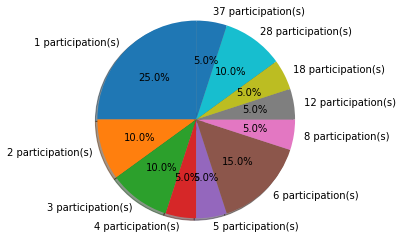

In [8]:
# Pie chart

number_participations = [0 for i in range(len(african_participant))]

for a in range(len(african_participant)):
    number_participations[a] = data.shape[1] - sum(np.isnan(data[african_participant][a]))

number_participations.sort()
#a = [1,1,1,1,2,2,2,2,3,3,4,5,5]

from collections import Counter
participations=Counter(number_participations)

#participations.values(),participations.keys()

labels = [str(i)+' participation(s)' for i in participations.keys()]
sizes = participations.values()
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', #explode=explode,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

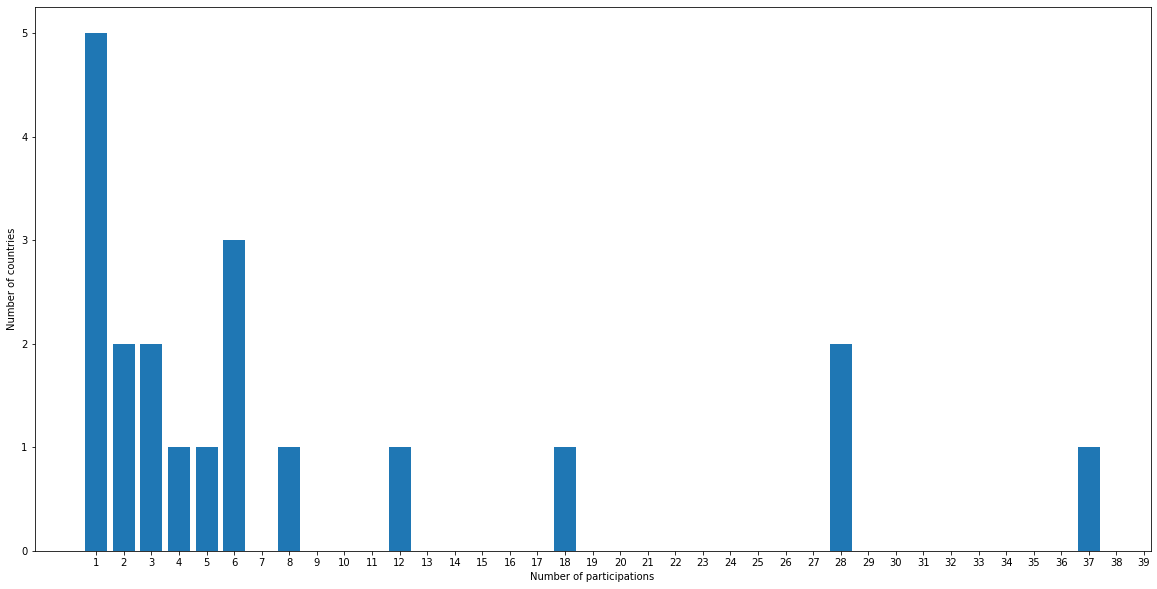

In [9]:
# Bar chart of number of participations of African countries

hist = [0 for i in range(len(african_participant))]

for a in range(len(african_participant)):
    hist[a] = data.shape[1] - sum(np.isnan(data[african_participant][a]))

u, inv = np.unique(hist, return_inverse=True)
counts = np.bincount(inv)

figure(figsize=(20,10))

plt.bar(u, counts) #, width=0.3

plt.xticks(np.arange(1,40))
plt.xlabel('Number of participations')
plt.ylabel('Number of countries')
#plt.title('Participation of African countries to the IMO')
plt.show()

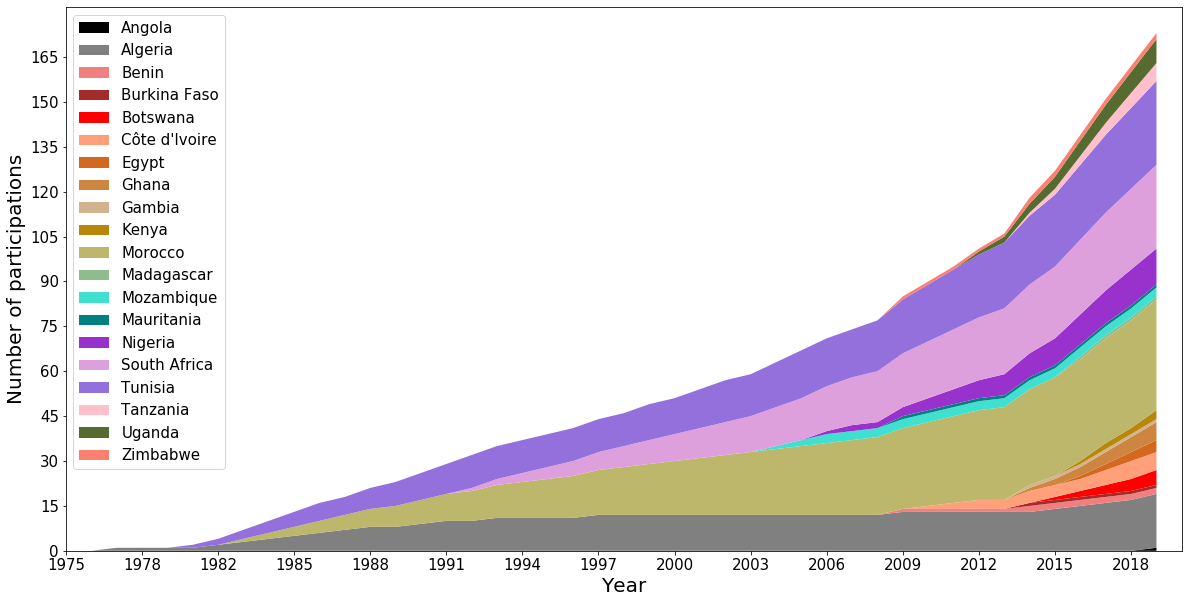

In [66]:
# Stacked area chart

participations = np.array([np.cumsum([1-np.isnan(data[african_participant][a][y]) for y in range(len(year))][::-1]) for a in range(len(african_participant))])

mycolors = ['black','gray','lightcoral','brown','red','lightsalmon','chocolate','peru','tan','darkgoldenrod',
            'darkkhaki','darkseagreen','turquoise','teal','darkorchid','plum','mediumpurple','pink','darkolivegreen','salmon']

figure(figsize=(20,10))
plt.stackplot(range(len(year)),participations, colors = mycolors, labels=name[african_participant])

plt.yaxis.tick_right()
plt.yticks(np.arange(0,sum(np.max(participations,axis=1)),15),fontsize=15)
plt.xticks(np.arange(1,len(year),3),year[np.arange(1,len(year),3)][::-1],fontsize=15)
plt.xlim(16,60)
plt.legend(loc='upper left',fontsize=15)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Number of participations',fontsize=20)

plt.show()

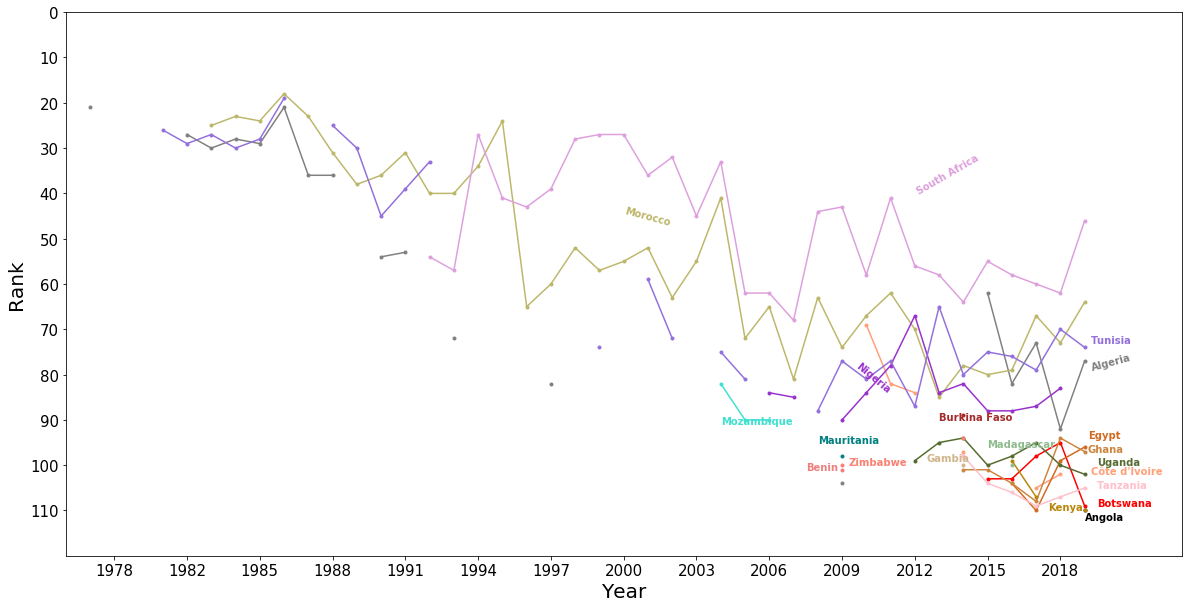

In [183]:
# Plot: for each African country, evolution of its performance at IMO

figure(figsize=(20,10))

for i in range(len(african_participant)):
    plt.plot(data[african_participant][i][::-1],'.-',color = mycolors[i],label=name[african_participant][i])

plt.xlabel('Year',fontsize=20)
plt.ylabel('Rank',fontsize=20)

plt.yticks(np.arange(0,120,10),fontsize=15)
plt.xticks(np.arange(1,len(year),3),year[np.arange(1,len(year),3)][::-1],fontsize=15)

plt.ylim(np.nanmax(data[african_participant])+10,0)
plt.xlim(17,63)

plt.text(x = 59, y = data[african_participant][0][::-1][-1]+2, s = name[african_participant][0], color = mycolors[0], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data[african_participant][1][::-1][-1]+2, s = name[african_participant][1], color = mycolors[1], rotation = 15, weight = 'bold')
plt.text(x = 47.5, y = data[african_participant][2][::-1][54]+3, s = name[african_participant][2], color = mycolors[2], rotation = 0, weight = 'bold')
plt.text(x = 53, y = data[african_participant][3][::-1][-6]+1, s = name[african_participant][3], color = mycolors[3], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data[african_participant][4][::-1][-1], s = name[african_participant][4], color = mycolors[4], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data[african_participant][5][::-1][-2], s = name[african_participant][5], color = mycolors[5], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data[african_participant][6][::-1][-1]-2, s = name[african_participant][6], color = mycolors[6], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data[african_participant][7][::-1][-1], s = name[african_participant][7], color = mycolors[7], rotation = 0, weight = 'bold')
plt.text(x = 52.5, y = data[african_participant][8][::-1][-6]-1, s = name[african_participant][8], color = mycolors[8], rotation = 0, weight = 'bold')
plt.text(x = 57.5, y = data[african_participant][9][::-1][-1], s = name[african_participant][9], color = mycolors[9], rotation = 0, weight = 'bold')
plt.text(x = 40, y = data[african_participant][10][::-1][40]-8, s = name[african_participant][10], color = mycolors[10], rotation = -15, weight = 'bold')
plt.text(x = 55, y = data[african_participant][11][::-1][-4]-4, s = name[african_participant][11], color = mycolors[11], rotation = 0, weight = 'bold')
plt.text(x = 44, y = data[african_participant][12][::-1][-14]+1, s = name[african_participant][12], color = mycolors[12], rotation = 0, weight = 'bold')
plt.text(x = 48, y = data[african_participant][13][::-1][-11]-3, s = name[african_participant][13], color = mycolors[13], rotation = 0, weight = 'bold')
plt.text(x = 49.5, y = data[african_participant][14][::-1][-10], s = name[african_participant][14], color = mycolors[14], rotation = -40, weight = 'bold')
plt.text(x = 52, y = data[african_participant][15][::-1][-9]-1, s = name[african_participant][15], color = mycolors[15], rotation = 30, weight = 'bold')
plt.text(x = 59.25, y = data[african_participant][16][::-1][-1]-1, s = name[african_participant][16], color = mycolors[16], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data[african_participant][17][::-1][-1], s = name[african_participant][17], color = mycolors[17], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data[african_participant][18][::-1][-1]-2, s = name[african_participant][18], color = mycolors[18], rotation = 0, weight = 'bold')
plt.text(x = 49.25, y = data[african_participant][19][::-1][-11], s = name[african_participant][19], color = mycolors[19], rotation = 0, weight = 'bold');

In [51]:
# Relative performance: rank divided by number of participants

data_standardized = np.array([[float('nan') for y in year] for i in code])

for i in range(len(code)):
    for y in range(len(year)):
        if not(math.isnan(data[i][y])):
            data_standardized[i][y] = np.divide(data[i][y],np.nanmax(data,axis=0)[y])

In [194]:
print('The previous statistics did not account for the variable number of participants. For example, rank 10 when there are 10 ')
print('participants should not be interpreted the same way as rank 10 when there are 100 countries. We need to standardize')
print('the performances.')
print(end='\n')
print(end='\n')

print(' - - Updated statistics - - ')
print(end='\n')
print(end='\n')

np.nanmin(data_standardized[african_participant],axis=1); # best relative performance for each African country

print('*',name[african_participant[np.argmin(np.nanmin(data_standardized[african_participant],axis=1))]],'achieved the best performance for an African country, ranking in the top', int(round(np.nanmin(data_standardized[african_participant])*100)),'% of participants in', year[np.nanargmin(data_standardized[african_participant[np.argmin(np.nanmin(data_standardized[african_participant],axis=1))]])],'.')
# Morocco, 

print(end='\n')
if (np.nanmax(data_standardized[african_participant]) == 1):
    print('* Worst performance for African countries, ranking as last participating country, has been achieved ',sum(sum(data_standardized[african_participant][a]==np.nanmax(data_standardized[african_participant]) for a in range(len(data_standardized[african_participant])-1))),' times.')
else:
        print('* Worst performance for African countries, ranking as last participating country ', np.nanmax(data_standardized[african_participant])*100, ', have been achieved ',sum(sum(data_standardized[african_participant][a]==np.nanmax(data_standardized[african_participant]) for a in range(len(data_standardized[african_participant])-1))),' times.')

The previous statistics did not account for the variable number of participants. For example, rank 10 when there are 10 
participants should not be interpreted the same way as rank 10 when there are 100 countries. We need to standardize
the performances.


 - - Updated statistics - - 


* Morocco achieved the best performance for an African country, ranking in the top 33 % of participants in 1995 .

* Worst performance for African countries, ranking as last participating country, has been achieved  12  times.


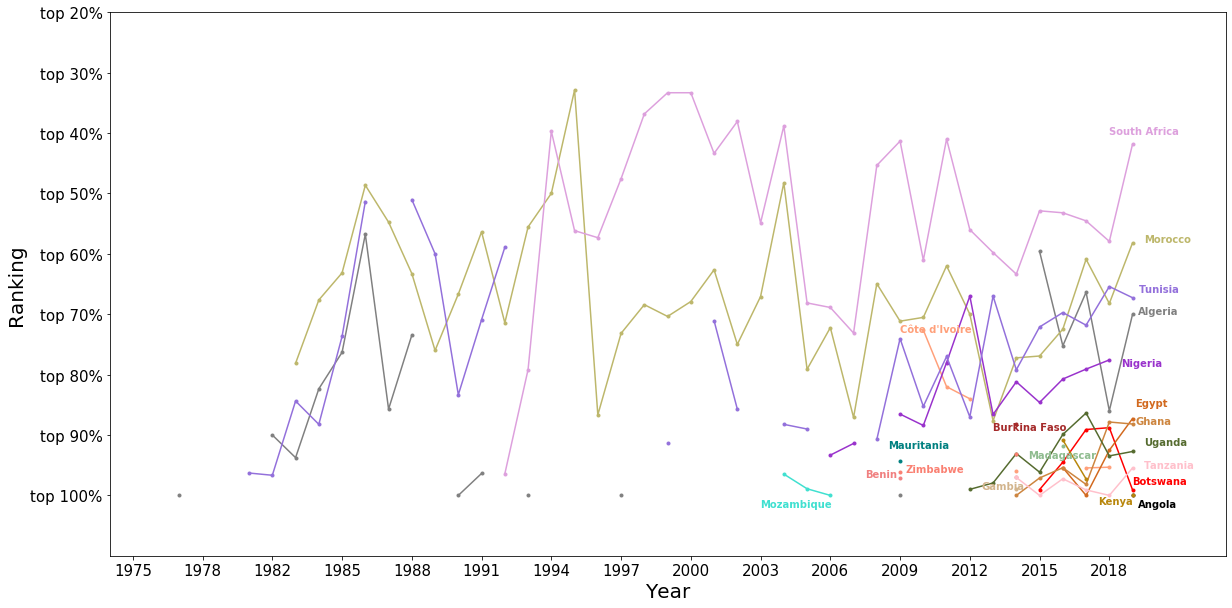

In [209]:
figure(figsize=(20,10))

for i in range(len(african_participant)):
    plt.plot(np.array(data_standardized)[african_participant][i][::-1],'.-',color = mycolors[i],label=np.array(name)[african_participant][i])

#plt.axes.set_xlim([15,63])
plt.xlabel('Year',fontsize=20)
plt.ylabel('Ranking',fontsize=20) #Standardized

plt.xticks(np.arange(1,len(year),3),year[np.arange(1,len(year),3)][::-1],fontsize=15)
plt.yticks(np.arange(0.2,1.1,0.1),np.array(['top 20%','top 30%','top 40%','top 50%','top 60%','top 70%','top 80%','top 90%','top 100%']),fontsize=15)

plt.ylim(1.1,0.2)
plt.xlim(15,63)

plt.text(x = 59.25, y = data_standardized[african_participant][0][::-1][-1]+0.02, s = name[african_participant][0], color = mycolors[0], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data_standardized[african_participant][1][::-1][-1], s = name[african_participant][1], color = mycolors[1], rotation = 0, weight = 'bold')
plt.text(x = 47.5, y = data_standardized[african_participant][2][::-1][-6], s = name[african_participant][2], color = mycolors[2], rotation = 0, weight = 'bold')
plt.text(x = 53, y = data_standardized[african_participant][3][::-1][-6]+0.01, s = name[african_participant][3], color = mycolors[3], rotation = 0, weight = 'bold')
plt.text(x = 59, y = data_standardized[african_participant][4][::-1][-1]-0.01, s = name[african_participant][4], color = mycolors[4], rotation = 0, weight = 'bold')
plt.text(x = 49, y = data_standardized[african_participant][5][::-1][-9]-0.09, s = name[african_participant][5], color = mycolors[5], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data_standardized[african_participant][6][::-1][-1]-0.02, s = name[african_participant][6], color = mycolors[6], rotation = 0, weight = 'bold')
plt.text(x = 59.125, y = data_standardized[african_participant][7][::-1][-1], s = name[african_participant][7], color = mycolors[7], rotation = 0, weight = 'bold')
plt.text(x = 52.5, y = data_standardized[african_participant][8][::-1][-6], s = name[african_participant][8], color = mycolors[8], rotation = 0, weight = 'bold')
plt.text(x = 57.5, y = data_standardized[african_participant][9][::-1][-1]+0.015, s = name[african_participant][9], color = mycolors[9], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data_standardized[african_participant][10][::-1][-10]-0.125, s = name[african_participant][10], color = mycolors[10], rotation = 0, weight = 'bold')
plt.text(x = 54.5, y = data_standardized[african_participant][11][::-1][-4]+0.02, s = name[african_participant][11], color = mycolors[11], rotation = 0, weight = 'bold')
plt.text(x = 43, y = data_standardized[african_participant][12][::-1][-14]+0.02, s = name[african_participant][12], color = mycolors[12], rotation = 0, weight = 'bold')
plt.text(x = 48.5, y = data_standardized[african_participant][13][::-1][-11]-0.02, s = name[african_participant][13], color = mycolors[13], rotation = 0, weight = 'bold')
plt.text(x = 58.5, y = data_standardized[african_participant][14][::-1][-2]+0.01, s = name[african_participant][14], color = mycolors[14], rotation = 0, weight = 'bold')
plt.text(x = 58, y = data_standardized[african_participant][15][::-1][35]-0.16, s = name[african_participant][15], color = mycolors[15], rotation = 0, weight = 'bold')
plt.text(x = 59.25, y = data_standardized[african_participant][16][::-1][-1]-0.01, s = name[african_participant][16], color = mycolors[16], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data_standardized[african_participant][17][::-1][-1], s = name[african_participant][17], color = mycolors[17], rotation = 0, weight = 'bold')
plt.text(x = 59.5, y = data_standardized[african_participant][18][::-1][-1]-0.01, s = name[african_participant][18], color = mycolors[18], rotation = 0, weight = 'bold')
plt.text(x = 49.25, y = data_standardized[african_participant][19][::-1][-11], s = name[african_participant][19], color = mycolors[19], rotation = 0, weight = 'bold');


In [13]:
# # Map: for each African country, its best performance at IMO

# Help: https://medium.com/using-specialist-business-databases/creating-a-choropleth-map-using-geopandas-and-financial-data-c76419258746

In [56]:
# Import world shape map externally (no need to have a saved file)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# view first 5 rows
# world.head()

#inspect count
# world.info()

In [57]:
# merge both data sets using country name as identifiers

score = pd.DataFrame({'abs_rank':np.nanmin(data[african_participant],axis=1),
                      'rel_rank':np.nanmin(data_standardized[african_participant],axis=1)},
                     index=name[african_participant]); # consider working with DataFrames from the beginning

for_plotting = world.merge(score, left_on = 'name', right_index=True) #for_plotting.info() #check the occurrence

C:\Users\djimd\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


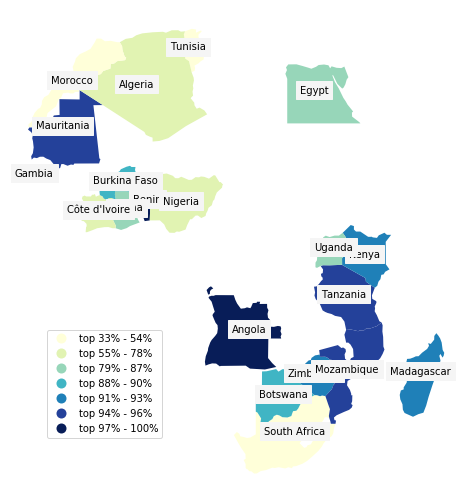

In [153]:
# Chloropeth Map

carte = for_plotting.plot(column='rel_rank', cmap =    
                                'YlGnBu', figsize=(15,9),   
                                 scheme='quantiles', k=7, legend =  
                                 True);
# Title
#carte.set_title('African countries best performances at the IMO', fontdict={'fontsize':15});

# Remove axes
carte.set_axis_off();

#move legend to an empty space
carte.get_legend().set_bbox_to_anchor((.35,.35));
leg = carte.get_legend()
leg.get_texts()[0].set_text('top 33% - 54%')
leg.get_texts()[1].set_text('top 55% - 78%')
leg.get_texts()[2].set_text('top 79% - 87%')
leg.get_texts()[3].set_text('top 88% - 90%')
leg.get_texts()[4].set_text('top 91% - 93%')
leg.get_texts()[5].set_text('top 94% - 96%')
leg.get_texts()[6].set_text('top 97% - 100%')
#carte.get_figure()

# Adding Labels (country names)

for_plotting['coords'] = for_plotting['geometry'].apply(lambda x: x.representative_point().coords)
for_plotting['coords'] = [coords[0] for coords in for_plotting['coords']]
for idx, row in for_plotting.iterrows():
    carte.annotate(s=row['name'], xy=row['coords'],horizontalalignment='center',backgroundcolor='whitesmoke') #
#carte.get_figure()